In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../../..')

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KAGGLE_USERNAME"] = "recsysaccelerate"
os.environ["KAGGLE_KEY"] = "6363e91b656fea576c39e4f55dcc1d00"

In [3]:
from replay.preprocessing.filters import MinCountFilter, NumInteractionsFilter
from replay.splitters import TimeSplitter
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

/opt/miniconda3/envs/replay_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

## Prepare data

In [5]:
interactions = pd.read_parquet("/RePlay-Accelerated/replay_benchmarks/data/games/interactions.parquet")

In [6]:
interactions

,user_id,item_id,rating,timestamp
1,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00TLEMSVK,4.0,1454675785000
4,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B007JWWUDW,5.0,1471542588000
5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B01C6FRASG,5.0,1456772324000
6,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0199PZFHE,5.0,1473288888000
7,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B083F7H29S,5.0,1473288935000
...,...,...,...,...
3861879,AH26WJSDXU4XDGSBXR3VXLDD6SJQ,B004PAKEFM,4.0,1356405851000
3861880,AH26WJSDXU4XDGSBXR3VXLDD6SJQ,B004PACAAO,4.0,1357365093000
3861883,AHMDS2PYZIJWE6SBXGDTBSJ4SRLA,B00BY2ER6G,5.0,1379155144000
3861884,AHMDS2PYZIJWE6SBXGDTBSJ4SRLA,B00I8Z6GAM,5.0,1420664276000


In [7]:
interactions['rating'].describe()

count    3.307579e+06
mean     4.852912e+00
std      3.541936e-01
min      4.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [8]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 430454
Number of unique items: 161901


In [9]:
pd.to_datetime(interactions['timestamp'], unit='ms').describe()

count                          3307579
mean     2018-11-04 03:42:45.163281408
min                2000-03-09 04:24:30
25%         2016-09-25 05:40:54.500000
50%      2019-01-28 16:17:23.830000128
75%      2021-01-17 06:40:49.941000192
max         2023-09-11 15:01:36.685000
Name: timestamp, dtype: object

In [10]:
pd.to_datetime(interactions['timestamp'], unit='ms')

1         2016-02-05 12:36:25
4         2016-08-18 17:49:48
5         2016-02-29 18:58:44
6         2016-09-07 22:54:48
7         2016-09-07 22:55:35
                  ...        
3861879   2012-12-25 03:24:11
3861880   2013-01-05 05:51:33
3861883   2013-09-14 10:39:04
3861884   2015-01-07 20:57:56
3861885   2015-01-07 20:59:48
Name: timestamp, Length: 3307579, dtype: datetime64[ns]

In [11]:
interactions.head()

,user_id,item_id,rating,timestamp
1,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00TLEMSVK,4.0,1454675785000
4,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B007JWWUDW,5.0,1471542588000
5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B01C6FRASG,5.0,1456772324000
6,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0199PZFHE,5.0,1473288888000
7,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B083F7H29S,5.0,1473288935000


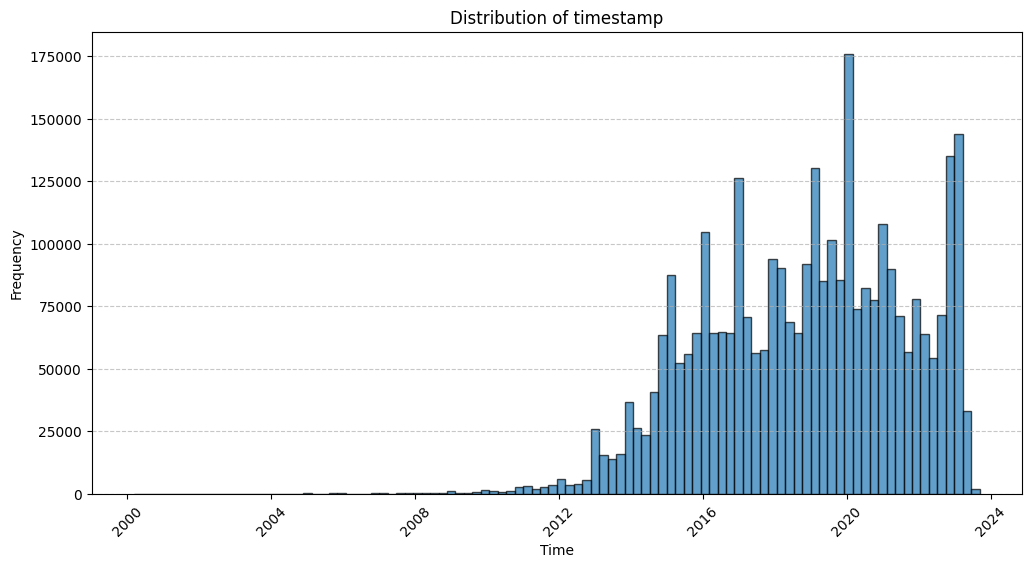

In [12]:
def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 'ms', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [13]:
# Фильтруем данные по минимальному рейтингу
interactions = interactions[
                interactions['rating']
                > 3
            ]

In [14]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 3


In [15]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 411352
Number of unique items: 143983


In [16]:
print(interactions.shape)
print(pd.to_datetime(interactions.timestamp.min(), unit='ms'))
print(pd.to_datetime(interactions.timestamp.max(), unit='ms'))
density = (len(interactions) / (interactions['user_id'].nunique() * interactions['item_id'].nunique())) * 100
print(f"Interaction Density: {density:.2f}%")
mean_seq_len = interactions.groupby('user_id').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.2f}")

(3213744, 4)
2000-03-09 04:24:30
2023-09-11 15:01:36.685000
Interaction Density: 0.01%
Mean Sequence Length: 7.81


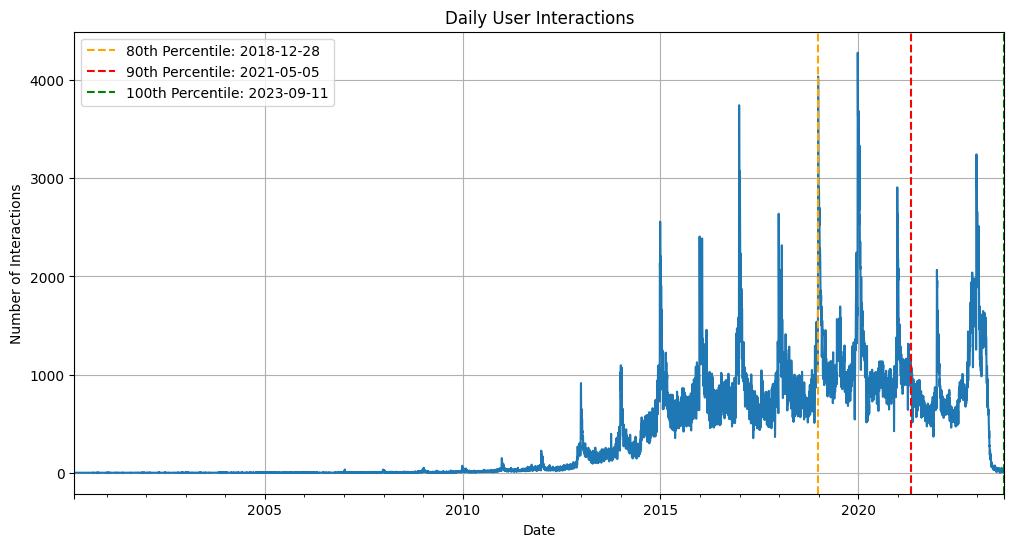

In [17]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='ms')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_80_date = daily_interactions.index[int(0.8 * len(daily_interactions)) - 1]
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_80_date, color='orange', linestyle='--', label=f'80th Percentile: {percentile_80_date.date()}')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'100th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=True,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )

    test_events, test_gt = splitter.split(interactions)
    validation_events, validation_gt = splitter.split(test_events)
    train_events = validation_events

    test_gt = test_gt[
        test_gt["item_id"].isin(train_events["item_id"])
    ]
    test_gt = test_gt[
        test_gt["user_id"].isin(train_events["user_id"])
    ]

    print(
        f"Distribution of seq_len in validation:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    max_test_interactions = 200

    if max_test_interactions is not None:

        validation_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(validation_gt)
        print(
            f"Distribution of seq_len in validation  after filtering:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )

        test_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(test_gt)
        print(
            f"Distribution of seq_len in test after filtering:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    else:
        print("max_num_test_interactions is null. Skipping filtration.")

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    83776.000000
mean         1.985425
std          1.955553
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         96.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    36525.000000
mean         1.702122
std          1.604849
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         51.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation  after filtering:
count    83776.000000
mean         1.985425
std          1.955553
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         96.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test after filtering:
count    36525.000000
mean         1.702122
std          1.604849
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         51.000000
Name: item_id, dtype: floa

In [19]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    """Prepare the feature schema based on whether ground truth is needed."""
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    return base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )

def prepare_datasets(
        train_events,
        validation_events,
        validation_gt,
        test_events,
        test_gt,
    ):
    """Prepare Dataset objects for training, validation, and testing."""
    train_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=train_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=validation_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=validation_gt,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=test_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=test_gt,
        check_consistency=True,
        categorical_encoded=False,
    )

    return (
        train_dataset,
        validation_dataset,
        validation_gt_dataset,
        test_dataset,
        test_gt_dataset,
    )

train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset = (
    prepare_datasets(*splits.values())
)
item_count = train_dataset.item_count

In [20]:
tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name="item_id_seq",
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[
            TensorFeatureSource(
                FeatureSource.INTERACTIONS,
                "item_id",
            )
        ],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=128,
    )
)

def initialize_tokenizer(train_dataset: Dataset, tensor_schema) -> SequenceTokenizer:
    """Initialize and fit the SequenceTokenizer."""
    tokenizer = SequenceTokenizer(
        tensor_schema, allow_collect_to_master=True, handle_unknown_rule="drop"
    )
    tokenizer.fit(train_dataset)
    return tokenizer

def prepare_sequential_validation(
        validation_dataset: Dataset, validation_gt: Dataset, tokenizer
    ):
    """Prepare sequential datasets for validation."""
    seq_validation_dataset = tokenizer.transform(validation_dataset)
    seq_validation_gt = tokenizer.transform(
        validation_gt, [tensor_schema.item_id_feature_name]
    )

    return SequentialDataset.keep_common_query_ids(
        seq_validation_dataset, seq_validation_gt
    )

def prepare_sequential_test(
    test_dataset: Dataset, test_gt: Dataset, tokenizer
) -> SequentialDataset:
    """Prepare sequential dataset for testing."""
    test_query_ids = test_gt.query_ids
    test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)[
        "user_id"
    ].values
    return tokenizer.transform(test_dataset).filter_by_query_id(
        test_query_ids_np
    )
    
def prepare_seq_datasets(
    train_dataset: Dataset,
    validation_dataset: Dataset,
    validation_gt: Dataset,
    test_dataset: Dataset,
    test_gt: Dataset,
):
    """Prepare SequentialDataset objects for training, validation, and testing."""
    tokenizer = initialize_tokenizer(train_dataset, tensor_schema)

    seq_train_dataset = tokenizer.transform(train_dataset)
    seq_validation_dataset, seq_validation_gt = prepare_sequential_validation(
        validation_dataset, validation_gt, tokenizer
    )
    seq_test_dataset = prepare_sequential_test(test_dataset, test_gt, tokenizer)

    return (
        seq_train_dataset,
        seq_validation_dataset,
        seq_validation_gt,
        seq_test_dataset,
    )

(
    seq_train_dataset,
    seq_validation_dataset,
    seq_validation_gt,
    seq_test_dataset,
    ) = prepare_seq_datasets(train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset)

In [21]:
# Valid_dataset 
exploded_df = seq_validation_dataset._sequences.explode(seq_validation_dataset._item_id_column)
unique_item_ids = exploded_df[seq_validation_dataset._item_id_column].unique()
unique_query_ids = seq_validation_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_dataset._sequences[seq_validation_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 99925
Number of unique query_ids: 83776


count    83776.000000
mean         6.158912
std         12.287025
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max       1895.000000
Name: item_id_seq, dtype: float64

In [22]:
# Valid_gt 
exploded_df = seq_validation_gt._sequences.explode(seq_validation_gt._item_id_column)
unique_item_ids = exploded_df[seq_validation_gt._item_id_column].unique()
unique_query_ids = seq_validation_gt._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_gt._sequences[seq_validation_gt._item_id_column].apply(len)
print(sequence_lengths.describe())
print(splits['validation_gt'].shape)

Number of unique item_ids: 45193
Number of unique query_ids: 83776
count    83776.000000
mean         1.985425
std          1.955553
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         96.000000
Name: item_id_seq, dtype: float64
(166331, 4)


In [23]:
# Test_dataset 
exploded_df = seq_test_dataset._sequences.explode(seq_test_dataset._item_id_column)
unique_item_ids = exploded_df[seq_test_dataset._item_id_column].unique()
unique_query_ids = seq_test_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_test_dataset._sequences[seq_test_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 77165
Number of unique query_ids: 36525


count    36525.000000
mean         6.950664
std         15.396233
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max       1966.000000
Name: item_id_seq, dtype: float64

In [24]:
# Test_gt
print(f"Number of unique item_ids: {splits['test_gt'].item_id.nunique()}")
print(f"Number of unique query_ids: {splits['test_gt'].user_id.nunique()}")
print(splits['test_gt'].groupby('user_id')['item_id'].agg('count').describe())
print(splits['test_gt'].shape)

Number of unique item_ids: 24863
Number of unique query_ids: 36525
count    36525.000000
mean         1.702122
std          1.604849
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         51.000000
Name: item_id, dtype: float64
(62170, 4)


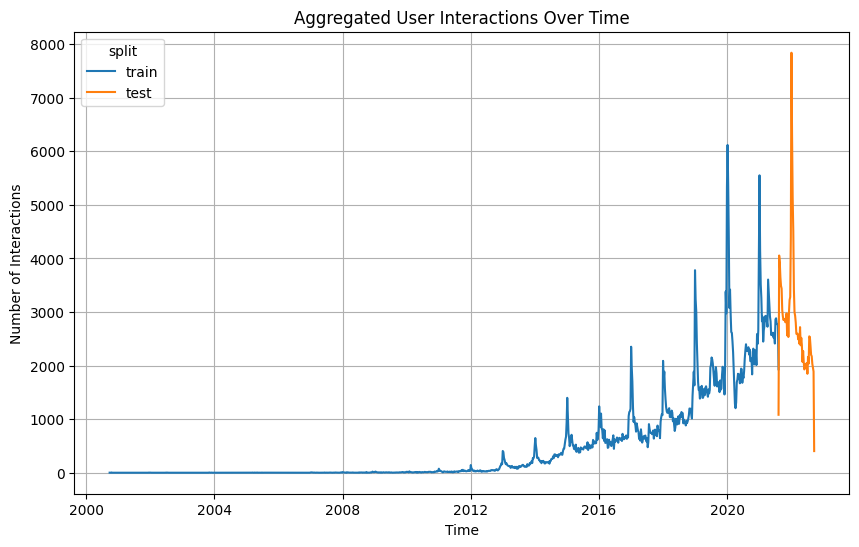

In [25]:
def plot_aggregated_interactions(train, test, time_unit='W'):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')

    train_agg = train.resample(time_unit, on='timestamp').size().reset_index(name='count')
    test_agg = test.resample(time_unit, on='timestamp').size().reset_index(name='count')

    train_agg['split'] = 'train'
    test_agg['split'] = 'test'

    combined_agg = pd.concat([train_agg, test_agg])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_agg, x='timestamp', y='count', hue='split')
    plt.title('Aggregated User Interactions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Interactions')
    plt.grid(True)
    plt.show()

val = splits['validation'][splits['validation'].user_id.isin(splits['validation_gt'].user_id.unique())]
val_gt = splits['validation_gt']
plot_aggregated_interactions(val, val_gt)

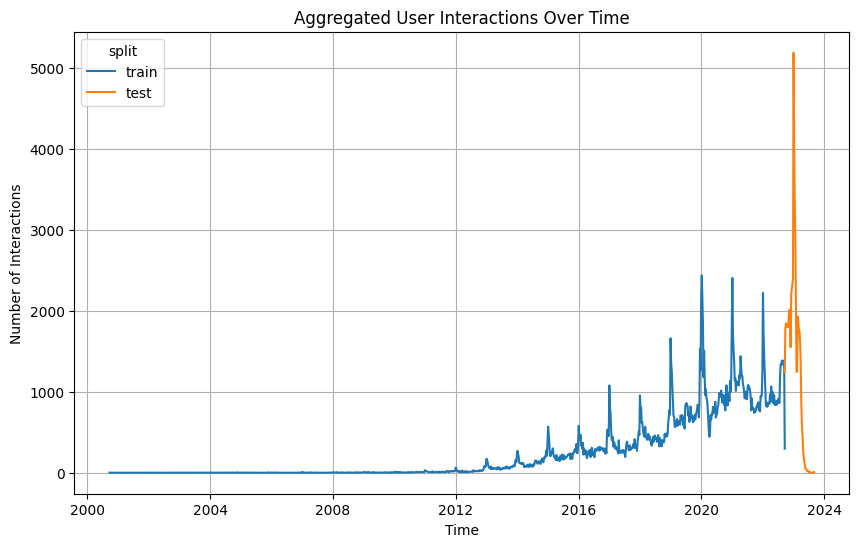

In [26]:
test = splits['test'][splits['test'].user_id.isin(splits['test_gt'].user_id.unique())]
test_gt = splits['test_gt']
plot_aggregated_interactions(test, test_gt)

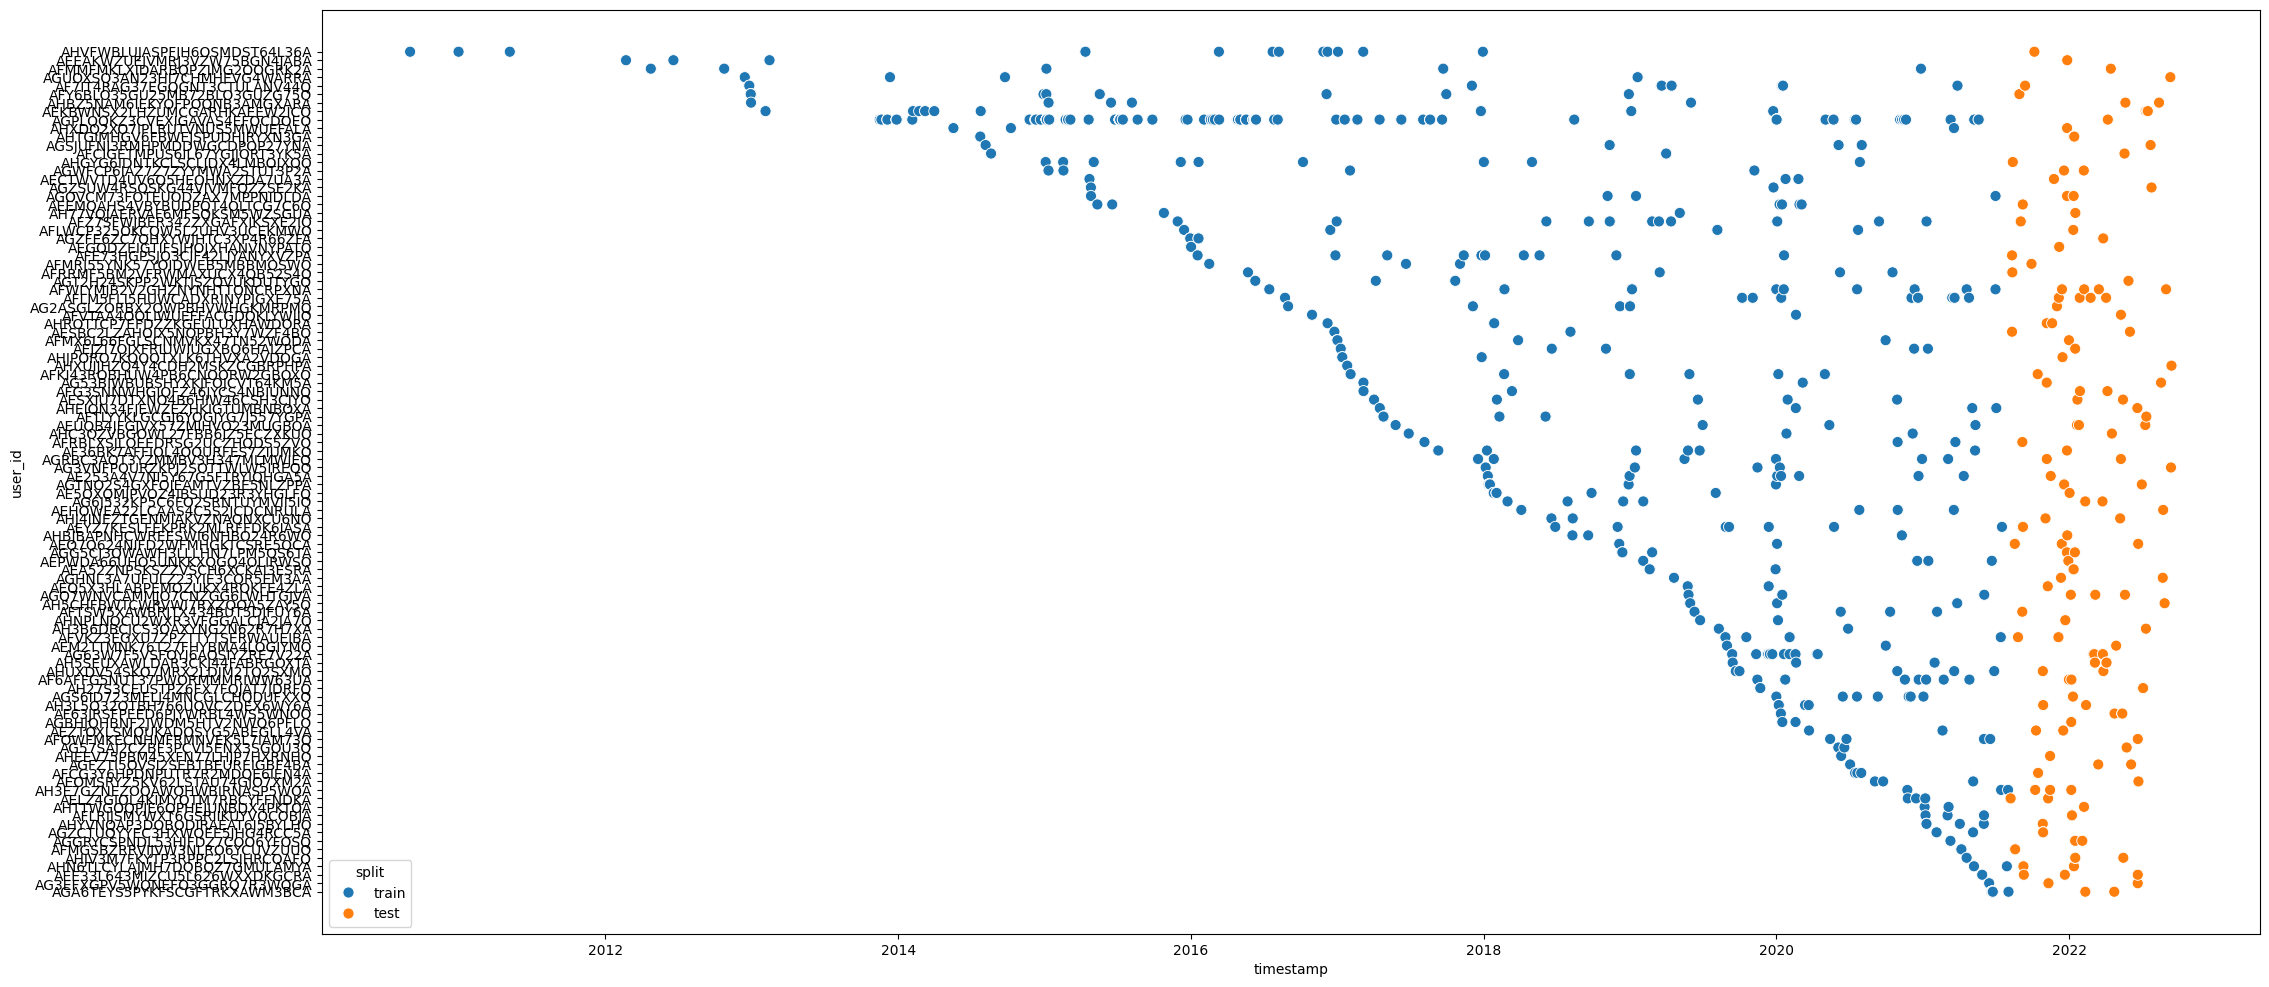

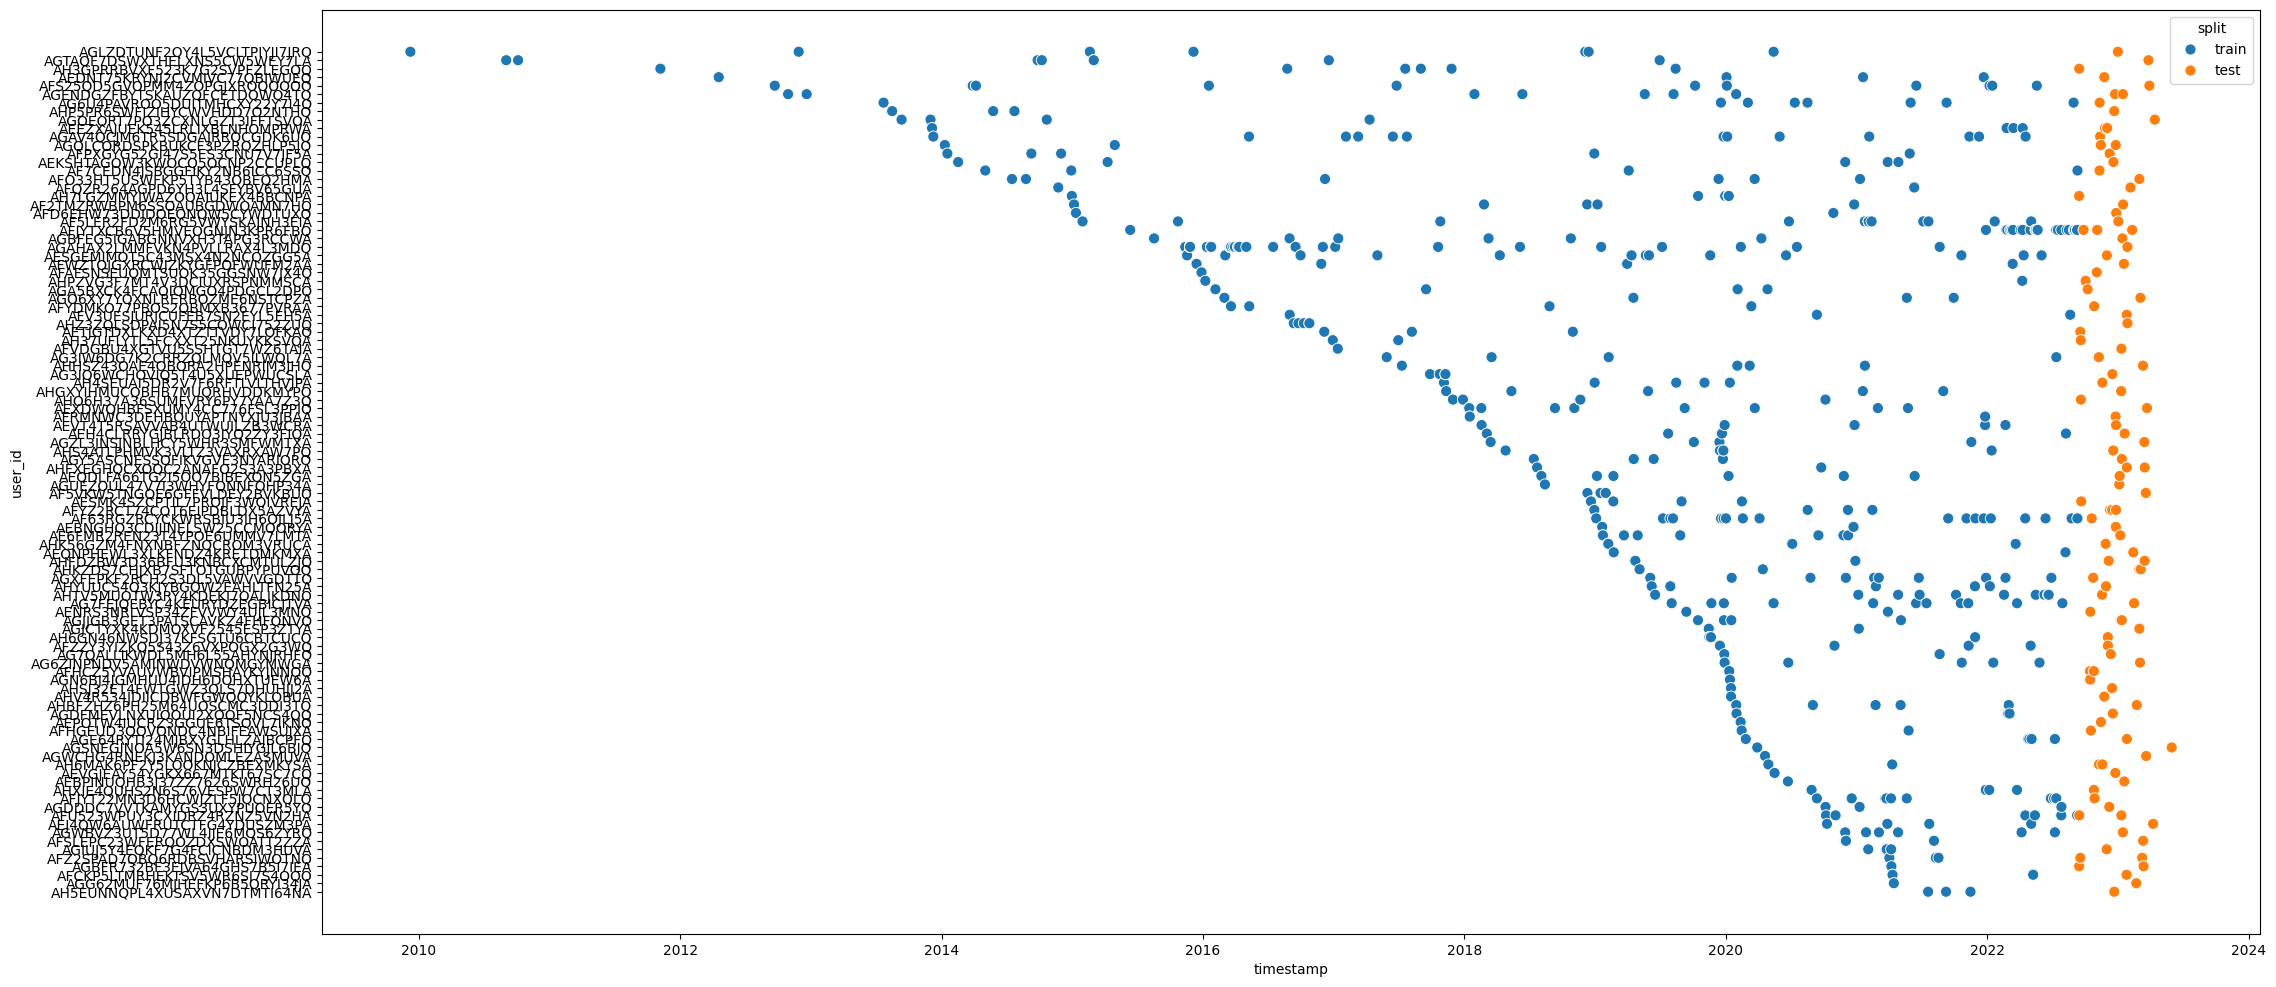

In [27]:
def show_train_test_sampled(train, test, sample_size=100):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ms')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ms')
    train['split'] = 'train'
    test['split'] = 'test'
    combined = pd.concat([train, test])
    sampled_user_ids = np.random.choice(combined['user_id'].unique(), size=sample_size, replace=False)

    sampled_data = combined[combined['user_id'].isin(sampled_user_ids)]
    plt.figure(figsize=(25, 12))
    sns.scatterplot(data=sampled_data, x='timestamp', y='user_id', hue='split', s=64)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()


show_train_test_sampled(val, val_gt)
show_train_test_sampled(test, test_gt)

In [28]:
splits['train'][splits['train'].user_id.isin(test_gt.user_id)]

,user_id,item_id,rating,timestamp
2497719,AFCRNFFGWWBTH5C3ZXNG42NC66BA,B00000IWEW,4.0,969245652000
1875208,AEGDEEMTAV662AVWX7WDMSSJPDMQ,B00000GBQL,5.0,976724543000
49803,AGXFIFO4VWNHPAX3VJPRQ2QJSCSQ,B00000IWH9,5.0,978975886000
49804,AGXFIFO4VWNHPAX3VJPRQ2QJSCSQ,B00000IWDB,5.0,984682199000
1596327,AFNIQBRCG5YM4UO6X3Z5DKBVPHPA,B00004TFZI,5.0,987713784000
...,...,...,...,...
1613496,AEUJL5GNUCJIBV32QJY7D77XVZKQ,B000B74E9A,5.0,1628298524959
687605,AFMQGNZBWKNS7RHDNBTT3ANCHERQ,B00I0H4AII,5.0,1628298965097
2605725,AGRUS7GKIXTAVRAFR64DJ36VSFAA,B0C3MRXNYL,5.0,1628299065045
2781232,AG3UJQRFC35A5RCN6R3QLD65DDSQ,B07YNJRHYL,5.0,1628299274145


In [29]:
len(set(splits['train'].item_id))

121210

In [30]:
len(set(val_gt.item_id))

45193

In [31]:
len(set(test_gt.item_id)) 

24863

In [32]:
len(set(test_gt.item_id) - set(val_gt.item_id))

4911

In [33]:
splits['train'][splits['train'].item_id.isin(set(test_gt.item_id) - set(val_gt.item_id))]

,user_id,item_id,rating,timestamp
3853705,AFQMMS73HMBXA53UR5FK6QIPLMTQ,B0943KMJ6L,4.0,1042302937000
3377696,AFVKMY3TTSPJLVEOARSA7DXOZSIQ,B00006LU8M,5.0,1047967676000
2838324,AGX5S76MVSS6SA7UHJK4MGZOELFA,B00000JIVS,5.0,1111699204000
1371139,AGSNPUOW7CU4J4SZYVM5NOKX5ZWQ,B001EHD9L0,5.0,1113180886000
3078036,AEHQVZYRSPFJOM7QZAXKFV67GBJQ,B001EHD9L0,5.0,1117141547000
...,...,...,...,...
3475257,AGJGTYZQGNAGRE5XJX5QDQROVTKQ,B08X1DZHFD,5.0,1628282739135
2742192,AHPWIH5EUOXHCZXYOUE3EY6SLWPA,B00GS1TBE6,5.0,1628294708382
1355096,AENSGFKPKS74NSKTC2GKNGVBZFTA,B07W98NY1B,4.0,1628295874309
2741379,AGA4M4YZATIP3HVBDOSTEWSDBN5A,B092FJN9X4,4.0,1628296876476


In [34]:
len(set(val_gt.item_id) - set(test_gt.item_id))

25241

In [35]:
splits['train'][splits['train'].item_id.isin(set(val_gt.item_id) - set(test_gt.item_id))]

,user_id,item_id,rating,timestamp
732225,AHR7ZC2G4VF4MEJMXTZANR23OJ6Q,B00004SDAP,5.0,964810411000
1297828,AHDKX4M4NYU56VCWPTD46C4OX2ZQ,B00000IZOU,5.0,968096009000
2346822,AHP2U6FGYANXMPNQZBXTBURYT5MA,B00000IUBJ,4.0,970365162000
3387215,AE7AWBG6XDXNNKE7NRWNPMVUQVLA,B091ZXRWKV,5.0,973448105000
3727672,AGVVUXNUSODM2KPKT5Y7TP2U3SHA,B00003G1TZ,5.0,975471270000
...,...,...,...,...
3492755,AEFFXE2QMAL576Y5TSOUP7GNG37A,B091BN2SQ5,4.0,1628298562731
1210173,AHZMACD3PEHZ6U6NKVM2QOJ4KBAA,B07VWCJXK2,5.0,1628298893499
687605,AFMQGNZBWKNS7RHDNBTT3ANCHERQ,B00I0H4AII,5.0,1628298965097
2798340,AGEFJVJ56CKNHLBNZ4CC2SSX3GHA,B093SSVL84,5.0,1628299319073


In [36]:
test_gt

,user_id,item_id,rating,timestamp
2089522,AGOV5YBAPWAORUTX536ZZAQMO6JQ,B0B8XW1ZYW,5.0,1663098900556
1239211,AGGPS3TYQXQ3OVBSPMC372NOW3WQ,B083TCFX5L,5.0,1663098911263
195148,AEOQUQ6BJHPTCZM3GUQD63UUNNZQ,B06XHTJ4JT,5.0,1663099052578
445113,AGYYD4XVPTOR5XIO3KNQUWF7VJNQ,B0BRRKZCQL,4.0,1663099133092
1388659,AFVUH3TWA7DARGYBUICVFM7QRRQA,B084QDNDKK,5.0,1663099633020
...,...,...,...,...
3857576,AHPW67TPDI5A352E2LLZAZDYZEUQ,B07GS6HXQP,5.0,1693417988896
3857577,AHPW67TPDI5A352E2LLZAZDYZEUQ,B09SPNF9TH,4.0,1693418081282
3857578,AHPW67TPDI5A352E2LLZAZDYZEUQ,B019I79ZG0,4.0,1693418243181
3857579,AHPW67TPDI5A352E2LLZAZDYZEUQ,B07PHDYZXN,4.0,1693418315174


In [37]:
test_gt[test_gt.item_id.isin(val_gt.item_id.unique())]

,user_id,item_id,rating,timestamp
2089522,AGOV5YBAPWAORUTX536ZZAQMO6JQ,B0B8XW1ZYW,5.0,1663098900556
445113,AGYYD4XVPTOR5XIO3KNQUWF7VJNQ,B0BRRKZCQL,4.0,1663099133092
1388659,AFVUH3TWA7DARGYBUICVFM7QRRQA,B084QDNDKK,5.0,1663099633020
1219626,AEZTY6W3MPFZWBPC473IPVQNM5DQ,B077Z1R28P,5.0,1663099756919
2074801,AEWXCCTECCQ2V4KYBAN7R4736YMA,B07D8K8J8X,5.0,1663100552219
...,...,...,...,...
3857576,AHPW67TPDI5A352E2LLZAZDYZEUQ,B07GS6HXQP,5.0,1693417988896
3857577,AHPW67TPDI5A352E2LLZAZDYZEUQ,B09SPNF9TH,4.0,1693418081282
3857578,AHPW67TPDI5A352E2LLZAZDYZEUQ,B019I79ZG0,4.0,1693418243181
3857579,AHPW67TPDI5A352E2LLZAZDYZEUQ,B07PHDYZXN,4.0,1693418315174
